In [1]:
# mount my Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# change directories
%cd ./gdrive/Othercomputers/My iMac/Data_Science/ML_EndToEnd_Projects/ml_project

/content/gdrive/Othercomputers/My iMac/Data_Science/ML_EndToEnd_Projects/ml_project


In [3]:
# install/import the dependencies
!pip install -U mrmr_selection catboost -q

from typing import Tuple, List, Dict, Any
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from yaml import SafeLoader
from mrmr import mrmr_regression
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier, 
    RandomForestRegressor, 
    AdaBoostRegressor, 
    GradientBoostingRegressor
)
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 9.0 MB/s eta 0:00:00


In [4]:
# set sklearn's display configuration
set_config(display="diagram")

In [5]:
# read 'student.csv' in as a Pandas DataFrame
df = pd.read_csv(r"./notebooks/data/student.csv")

# output five random records from the 'df' DataFrame
df.sample(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
316,female,group D,master's degree,standard,completed,77,82,91.0
318,male,group B,bachelor's degree,NaN,none,63,71,69.0
32,female,group E,master's degree,free/reduced,none,56,72,65.0
163,male,group C,high school,standard,none,52,53,49.0
989,female,group D,some college,free/reduced,completed,67,86,83.0


In [6]:
## STEP 1: read in the parameters from ./conf/parameters.yml
def get_params(path: str) -> Dict[str, Any]:
  """
  Returns the parameters defined in path

  Args:
    path: ./conf/parameters.yml

  Returns:
    params: Parameters defined in path
  """
  with open(path) as fp:
    params = yaml.load(fp, Loader=SafeLoader)
    return params

In [7]:
parameters = get_params(r"./conf/parameters.yml")
parameters

{'target': 'math_score',
 'numeric_features': ['reading_score', 'writing_score'],
 'nominal_features': ['gender',
  'race_ethnicity',
  'lunch',
  'test_preparation_course'],
 'ordinal': {'features': ['parental_level_of_education'],
  'categories': ['some high school',
   'high school',
   'some college',
   "associate's degree",
   "bachelor's degree",
   "master's degree"]},
 'test_size': 0.2,
 'random_state': 42,
 'grid_search_cv': {'param_grid': {'RandomForestRegression': {'n_estimators': [100,
     200,
     500],
    'max_depth': [3, 5, 8, 20],
    'max_features': ['sqrt', 'log2']},
   'AdaBoostRegression': {'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]},
   'GradientBoostingRegression': {'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
   'CatBoostRegression': {'depth': [3, 5, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'iterations': [20, 50, 100]},
   'XGBRegression

In [8]:
## STEP 2: split the data into train and test sets
def split_data(
    data: pd.DataFrame, 
    params: Dict[str, Any]
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits data into train and test sets

    Args:
        data: Data containing features and target

    Returns:
        train_set: Train set with missing values
        test_set: Test set with missing values
    """
    target = params["target"]
    train_set, test_set = train_test_split(
        data, 
        test_size=params["test_size"],  
        random_state=params["random_state"]
    )

    train_set = train_set.reset_index(drop=True)
    test_set = test_set.reset_index(drop=True)
    return train_set, test_set

In [9]:
train_set, test_set = split_data(df, parameters)

In [10]:
# output five random records from the train set
train_set.sample(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
489,male,NaN,associate's degree,standard,none,80,76,64.0
36,male,group C,associate's degree,standard,none,46,43,42.0
21,female,NaN,some college,free/reduced,none,53,58,57.0
307,female,group E,some high school,free/reduced,none,38,49,NaN
91,male,NaN,high school,standard,none,70,70,70.0


In [11]:
# output five random records from the test set
test_set.sample(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
111,female,group B,high school,free/reduced,none,71,87,82.0
9,male,group B,some high school,standard,completed,51,54,41.0
164,male,group D,some college,standard,completed,82,82,NaN
115,male,group C,high school,standard,none,61,56,55.0
159,female,group E,associate's degree,standard,none,51,51,54.0


In [12]:
# percentage of missing values for each column in the train set
(train_set.isna().sum() / train_set.shape[0]).round(2).sort_values(ascending=False)

race_ethnicity                 0.16
writing_score                  0.13
lunch                          0.06
test_preparation_course        0.03
gender                         0.00
parental_level_of_education    0.00
math_score                     0.00
reading_score                  0.00
dtype: float64

In [13]:
# percentage of missing values for each column in the test set
(test_set.isna().sum() / test_set.shape[0]).round(2).sort_values(ascending=False)

writing_score                  0.14
race_ethnicity                 0.12
lunch                          0.09
test_preparation_course        0.03
gender                         0.00
parental_level_of_education    0.00
math_score                     0.00
reading_score                  0.00
dtype: float64

In [14]:
## STEP 3: impute the train and test set features that have missing values
def impute_data(
        train_set: pd.DataFrame, 
        test_set: pd.DataFrame, 
        params: Dict[str, Any]
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns the imputed train and test sets

    Args:
        train_set: Train set with missing values
        test_set: Test set with missing values

    Returns:
        train_set_imputed: Train set with imputed values
        test_set_imputed: Test set with imputed values
    """
    target = params["target"]
    X_train, y_train = train_set.drop(target, axis=1), train_set[target]
    X_test, y_test = test_set.drop(target, axis=1), test_set[target]
    X_train_imputed = X_train.copy(deep=True)
    X_test_imputed = X_test.copy(deep=True)
    num_cols = params["numeric_features"]
    cat_cols = params["nominal_features"] + params["ordinal"]["features"]
    null_cols = [
        col
        for col in num_cols + cat_cols
        if X_train[col].isna().sum() > 0
    ]

    # label encode the non-null categorical features
    for cat_col in cat_cols:
        if cat_col not in null_cols:
            categories = sorted(set(X_train[cat_col]))
            cat_to_idx = dict(zip(categories, range(len(categories))))
            X_train[cat_col] = X_train[cat_col].map(cat_to_idx).astype("int")
            X_test[cat_col] = X_test[cat_col].map(cat_to_idx).astype("int")

    for col in null_cols:
        features = [
            feature
            for feature in num_cols + cat_cols
            if feature not in null_cols
        ]
        # categorical feature imputation
        if (col in cat_cols) or (len(set(X_train[col].dropna())) <= 10):
            features += [col]
            train = X_train[features].copy(deep=True)
            train_notna = train[train[col].notna()].copy(deep=True)
            train_isna = train[train[col].isna()].copy(deep=True)
            train_indices_to_impute = train_isna.index.tolist()
            model = RandomForestClassifier()
            model.fit(train_notna.drop(col, axis=1), train_notna[col])
            test = X_test[features].copy(deep=True)
            test_isna = test[test[col].isna()].copy(deep=True)
            test_indices_to_impute = test_isna.index.tolist()
            X_train_imputed.loc[train_indices_to_impute, col] = model.predict(train_isna.drop(col, axis=1))
            X_test_imputed.loc[test_indices_to_impute, col] = model.predict(test_isna.drop(col, axis=1))
        # numeric feature imputation
        else:
            features += [col]
            train = X_train[features].copy(deep=True)
            train_notna = train[train[col].notna()].copy(deep=True)
            train_isna = train[train[col].isna()].copy(deep=True)
            train_indices_to_impute = train_isna.index.tolist()
            model = RandomForestRegressor()
            model.fit(train_notna.drop(col, axis=1), train_notna[col])
            test = X_test[features].copy(deep=True)
            test_isna = test[test[col].isna()].copy(deep=True)
            test_indices_to_impute = test_isna.index.tolist()
            X_train_imputed.loc[train_indices_to_impute, col] = model.predict(train_isna.drop(col, axis=1))
            X_test_imputed.loc[test_indices_to_impute, col] = model.predict(test_isna.drop(col, axis=1))

    # concatenate the train and test set imputed features and target
    train_set_imputed = pd.concat([X_train_imputed, y_train], axis=1).reset_index(drop=True)
    test_set_imputed = pd.concat([X_test_imputed, y_test], axis=1).reset_index(drop=True)
    return train_set_imputed, test_set_imputed

In [15]:
train_set, test_set = impute_data(train_set, test_set, parameters)

In [16]:
# confirm that all missing values have been imputed
assert train_set.isna().sum().sum() == 0
assert test_set.isna().sum().sum() == 0

In [17]:
## STEP 4: processes the train and test set features
def transform_features(
    train_set: pd.DataFrame, 
    test_set: pd.DataFrame, 
    params: Dict[str, Any]
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Returns ML-ready train and test set features and targets

    Args:
      train_set: Train set with no missing values  
      test_set: Test set with no missing values
      params: Parameters defined ./conf/parameters.yml 

    Returns:
      X_train: ML-ready train set feature matrix
      X_test: ML-ready test set features matrix
      y_train: Train set target vector
      y_test: Test set target vector
    """
    target = params["target"]
    X_train = train_set.drop(target, axis=1)
    y_train = train_set[target]
    X_test = test_set.drop(target, axis=1)
    y_test = test_set[target]
    
    # create a ColumnTransformer instance to transform the features
    ct = ColumnTransformer([
            (
                "numeric_features", 
                StandardScaler(), 
                params["numeric_features"]
             ), 
            (
                "nominal_features", 
                OneHotEncoder(sparse_output=False, handle_unknown="ignore"), 
                params["nominal_features"]
            ), 
            (
                "ordinal_features", 
                OrdinalEncoder(categories=[params["ordinal"]["categories"]]), 
                params["ordinal"]["features"]
            )
        ])

    # fit the ColumnTransformer instance to the train set features
    ct.fit(X_train)

    # extract the categories from the features that were one-hot encoded
    ohe_categories = []
    for arr in ct.transformers_[1][1].categories_:
      ohe_categories += [
          category.lower().replace(" ", "_").replace("/", "_") 
          for category in arr.tolist()
      ]

    features = params["numeric_features"] + ohe_categories + params["ordinal"]["features"]
  
    # transform the train and test set features
    X_train = pd.DataFrame(
        ct.transform(X_train), columns=features, index=X_train.index.tolist()
        )
    X_test = pd.DataFrame(
        ct.transform(X_test), columns=features, index=X_test.index.tolist()
        )
    
    # select the K most relevant, least redundant features
    rel_features = mrmr_regression(
        X=X_train, 
        y=y_train, 
        K=int(np.random.choice([0.5, 0.6, 0.7, 0.8]) * len(features)), 
        relevance="f", 
        redundancy="c"
        )

    # filter X_train and X_test w.r.t. the most relevant, least redundant features
    X_train = X_train[rel_features].copy(deep=True)
    X_test = X_test[rel_features].copy(deep=True)

    return X_train, X_test, y_train, y_test

In [18]:
Xtrain, Xtest, ytrain, ytest = transform_features(train_set, test_set, parameters)

100%|██████████| 7/7 [00:00<00:00, 48.38it/s]


In [19]:
# confirm that all features are numeric
assert list(set(Xtrain.dtypes))[0] == np.number
assert list(set(Xtrain.dtypes))[0] == np.number

In [20]:
# output five random records from the ML-ready train set feature matrix
Xtrain.sample(5)

,reading_score,writing_score,free_reduced,group_e,standard,none,female
170,0.376752,0.107032,1.0,0.0,0.0,0.0,1.0
161,1.898981,1.829513,0.0,0.0,1.0,1.0,1.0
6,2.106557,2.100106,0.0,1.0,1.0,0.0,1.0
126,0.445944,0.372776,0.0,0.0,1.0,0.0,1.0
321,0.238367,0.173468,1.0,1.0,0.0,0.0,1.0


In [21]:
# output five random records from the ML-ready test set feature matrix
Xtest.sample(5)

,reading_score,writing_score,free_reduced,group_e,standard,none,female
72,-0.868708,-0.955940,1.0,0.0,0.0,1.0,0.0
65,0.307559,0.837826,1.0,0.0,0.0,0.0,1.0
169,0.445944,0.771390,0.0,0.0,1.0,1.0,1.0
90,0.791905,0.873203,1.0,0.0,0.0,1.0,0.0
94,-2.183361,-2.417527,0.0,0.0,1.0,1.0,1.0


In [22]:
## STEP 5: adjusted R²
def adj_rsquared(
    X: pd.DataFrame, 
    y: pd.Series, 
    yhat: np.ndarray
) -> float:
  """
  Returns the adjusted R²

  Args:
    X: feature matrix
    y: target vector
    yhat: prediction vector

  Returns:
    adj_r2: Adjusted R²
  """
  N, D = X.shape
  t = y - np.mean(y)
  sst = t.dot(t)
  e = y - yhat
  sse = e.dot(e)
  r2 = 1 - (sse / sst)
  adj_r2 = 1 - (((1 - r2) * (N - 1)) / (N - D - 1))
  return adj_r2

In [23]:
# train, predict, and evaluate
models = {
    "LinearRegression": LinearRegression(), 
    "LassoRegression": Lasso(), 
    "RidgeRegression": Ridge(), 
    "KNeighborsRegression": KNeighborsRegressor(),
    "SupportVectorRegression": SVR(), 
    "DecisionTreeRegression": DecisionTreeRegressor(), 
    "RandomForestRegression": RandomForestRegressor(), 
    "AdaBoostRegression": AdaBoostRegressor(), 
    "GradientBoostingRegression": GradientBoostingRegressor(), 
    "CatBoostRegression": CatBoostRegressor(verbose=False),
    "XGBRegression": XGBRegressor()   
}

report = {}
for name, model in models.items():
  # train the model
  model.fit(Xtrain, ytrain)

  # train set predictions and evaluation
  yhat_train = model.predict(Xtrain)
  adj_r2_train = np.round(adj_rsquared(Xtrain, ytrain, yhat_train), 4)

  # test set predictions and evaluation
  yhat_test = model.predict(Xtest)
  adj_r2_test = np.round(adj_rsquared(Xtest, ytest, yhat_test), 4)

  # map each model to its corresponding adjusted R² scores
  report[name] = [adj_r2_train, adj_r2_test]

In [24]:
# output the 'report' dictionary
report

{'LinearRegression': [0.8623, 0.8785],
 'LassoRegression': [0.8023, 0.8174],
 'RidgeRegression': [0.8623, 0.8785],
 'KNeighborsRegression': [0.8815, 0.8062],
 'SupportVectorRegression': [0.8044, 0.7174],
 'DecisionTreeRegression': [0.9964, 0.7322],
 'RandomForestRegression': [0.973, 0.8305],
 'AdaBoostRegression': [0.8434, 0.8509],
 'GradientBoostingRegression': [0.8943, 0.8615],
 'CatBoostRegression': [0.9338, 0.8448],
 'XGBRegression': [0.986, 0.8141]}

In [25]:
# output the model that produced the highest test set adjusted R²
(pd.DataFrame
 .from_dict(
    report,
    orient="index", 
    columns=["Adjusted_R²_Train", "Adjusted_R²_Test"]
 )
 .sort_values("Adjusted_R²_Test", ascending=False)
 .iloc[0, :]
 .to_frame()
 .T
 )

,Adjusted_R²_Train,Adjusted_R²_Test
LinearRegression,0.8623,0.8785


In [26]:
# sort the models, in descending order, w.r.t. the test set adjusted R²
sorted(report.items(), key=lambda kv: kv[1][1])[::-1]

[('RidgeRegression', [0.8623, 0.8785]),
 ('LinearRegression', [0.8623, 0.8785]),
 ('GradientBoostingRegression', [0.8943, 0.8615]),
 ('AdaBoostRegression', [0.8434, 0.8509]),
 ('CatBoostRegression', [0.9338, 0.8448]),
 ('RandomForestRegression', [0.973, 0.8305]),
 ('LassoRegression', [0.8023, 0.8174]),
 ('XGBRegression', [0.986, 0.8141]),
 ('KNeighborsRegression', [0.8815, 0.8062]),
 ('DecisionTreeRegression', [0.9964, 0.7322]),
 ('SupportVectorRegression', [0.8044, 0.7174])]

In [27]:
# select and output the 'best' model
best_model_name: str = sorted(report.items(), key=lambda kv: kv[1][1])[::-1][0][0]
best_model = models[best_model_name]
best_model

Ridge()

In [28]:
## STEP 6: train several regressors, select the one that produces the...
# highest test set adjusted R², and use it to make test set predictions
def train_evaluate_predict(
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: pd.Series, 
    y_test: pd.Series, 
    parameters: Dict[str, Any]
) -> pd.Series:
  """
  Trains and evaluates several models, selects the one that 
  produces the highest test set adjusted R², and uses it to 
  generate test set predictions

  Args:
    X_train: ML-ready train set feature matrix
    X_test: ML-ready test set features matrix
    y_train: Train set target vector
    y_test: Test set target vector
    parameters: Parameters defined in parameters.yml

  Returns:
    yhat_test: Test set prediction vector
    model_name: Name of the model that produced 
    the highest test set adjusted R² 
  """
  models = {
        "LinearRegression": LinearRegression(), 
        "RandomForestRegression": RandomForestRegressor(), 
        "AdaBoostRegression": AdaBoostRegressor(), 
        "GradientBoostingRegression": GradientBoostingRegressor(), 
        "CatBoostRegression": CatBoostRegressor(verbose=False), 
        "XGBRegression": XGBRegressor()
  }

  report = {}
  for name, model in models.items():
    if name == "LinearRegression":
      model.fit(X_train, y_train)
      train_predictions = model.predict(X_train)
      train_metric = adj_rsquared(X_train, y_train, train_predictions)
      test_predictions = model.predict(X_test)
      test_metric = adj_rsquared(X_test, y_test, test_predictions)
      report[name] = [model, train_metric, test_metric]
    else:
      gscv = GridSearchCV(
          estimator=model, 
          param_grid=parameters["grid_search_cv"]["param_grid"][name], 
          scoring=parameters["grid_search_cv"]["scoring"], 
          refit=parameters["grid_search_cv"]["refit"], 
          cv=parameters["grid_search_cv"]["cv"], 
          n_jobs=parameters["grid_search_cv"]["n_jobs"]
      )
      gscv.fit(X_train, y_train)
      train_predictions = gscv.predict(X_train)
      train_metric = adj_rsquared(X_train, y_train, train_predictions)
      test_predictions = gscv.predict(X_test)
      test_metric = adj_rsquared(X_test, y_test, test_predictions)
      report[name] = [gscv.best_estimator_, train_metric, test_metric]

  model_name: str = sorted(report.items(), key=lambda kv: kv[1][-1])[::-1][0][0]
  best_model = sorted(report.items(), key=lambda kv: kv[1][-1])[::-1][0][1][0]
  best_score: float = sorted(report.items(), key=lambda kv: kv[1][-1])[::-1][0][1][-1]
  
  if best_score < 0.65:
    raise Exception("No best model found")
  yhat_test = pd.Series(
      best_model.predict(X_test), 
      index=y_test.index.tolist()
  )
  print(
      f"{best_score:.2f}, the highest test set adjusted R², was produced via {model_name}"
  )
  
  return yhat_test

In [29]:
yhat_test = train_evaluate_predict(
    Xtrain, Xtest, ytrain, ytest, parameters
)

0.88, the highest test set adjusted R², was produced via LinearRegression


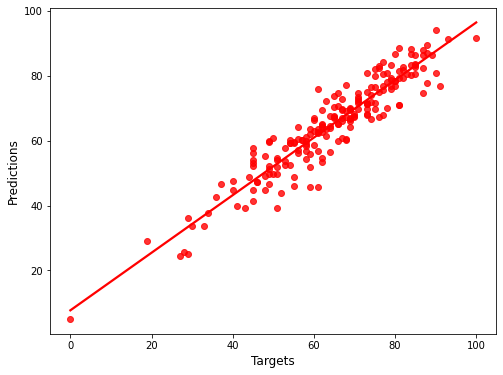

In [30]:
# scatter plot of the test set targets and predictions
plt.figure(figsize=(8, 6))
sns.regplot(x=ytest, y=yhat_test, ci=None, color="red")
plt.xlabel("Targets", fontsize=12)
plt.ylabel("Predictions", fontsize=12);

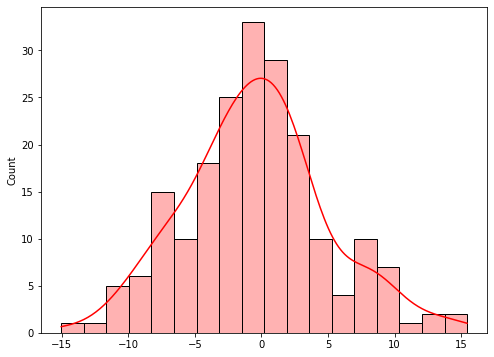

In [31]:
# distribution of test set errors
n_bins = int((1 + (3.322 * np.log(ytest.shape[0]))))
plt.figure(figsize=(8, 6))
sns.histplot(ytest-yhat_test, bins=n_bins, color="red", alpha=0.3, kde=True);